<a href="https://colab.research.google.com/github/rohansiddam/Python-Journey/blob/main/061%20-%20Lesson%2061%20(Simple%20Linear%20Regression%20-%20Residual%20Analysis).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 61: Simple Linear Regression - Residual Analysis


### Teacher-Student Activities

In this class, we will learn to evaluate the accuracy of a simple linear regression model by performing residual analysis as well.

Also, you will get introduced to multiple linear regression from this class.

Let's quickly run the codes covered in the previous classes and begin this session from **Activity 1: Residual (Error) Analysis** section.

---

### Recap

In [ ]:
# Run the code cell.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Loading the dataset.
csv_file = 'https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/whitehat-ds-datasets/air-quality/AirQualityUCI.csv'
df = pd.read_csv(csv_file, sep=';')

# Dropping the 'Unnamed: 15' & 'Unnamed: 16' columns.
df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16'], axis=1)

# Dropping the null values.
df = df.dropna()

# Creating a Pandas series containing 'datetime' objects.
dt_series = pd.Series(data = [item.split("/")[2] + "-" + item.split("/")[1] + "-" + item.split("/")[0] for item in df['Date']], index=df.index) + ' ' + pd.Series(data=[str(item).replace(".", ":") for item in df['Time']], index=df.index)
dt_series = pd.to_datetime(dt_series)

# Remove the Date & Time columns from the DataFrame and insert the 'dt_series' in it.
df = df.drop(columns=['Date', 'Time'], axis=1)
df.insert(loc=0, column='DateTime', value=dt_series)

# Get the Pandas series containing the year values as integers.
year_series = dt_series.dt.year

# Get the Pandas series containing the month values as integers.
month_series = dt_series.dt.month

# Get the Pandas series containing the day values as integers.
day_series = dt_series.dt.day

# Get the Pandas series containing the days of a week, i.e., Monday, Tuesday, Wednesday etc.
day_name_series = dt_series.dt.day_name()

# Add the 'Year', 'Month', 'Day' and 'Day Name' columns to the DataFrame.
df['Year'] = year_series
df['Month'] = month_series
df['Day'] = day_series
df['Day Name'] = day_name_series

# Sort the DataFrame by the 'DateTime' values in the ascending order. Also, display the first 10 rows of the DataFrame.
df = df.sort_values(by='DateTime')

# Create a function to replace the commas with periods in a Pandas series.
def comma_to_period(series):
    new_series = pd.Series(data=[float(str(item).replace(',', '.')) for item in series], index=df.index)
    return new_series

# Apply the 'comma_to_period()' function on the ''CO(GT)', 'C6H6(GT)', 'T', 'RH' and 'AH' columns.
cols_to_correct = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH'] # Create a list of column names.
for col in cols_to_correct: # Iterate through each column
    df[col] = comma_to_period(df[col]) # Replace the original column with the new series.

# Remove all the columns from the 'df' DataFrame containing more than 10% garbage value.
df = df.drop(columns=['NMHC(GT)', 'CO(GT)', 'NOx(GT)', 'NO2(GT)'], axis=1)

# Create a new DataFrame containing records for the years 2004 and 2005.
aq_2004_df = df[df['Year'] == 2004]
aq_2005_df = df[df['Year'] == 2005]

# Replace the -200 value with the median values for each column having indices between 1 and -4 (excluding -4) for the 2004 year DataFrame.
for col in aq_2004_df.columns[1:-4]:
  median = aq_2004_df.loc[aq_2004_df[col] != -200, col].median()
  aq_2004_df[col] = aq_2004_df[col].replace(to_replace=-200, value=median)

# Repeat the same exercise for the 2005 year DataFrame.
for col in aq_2005_df.columns[1:-4]:
  median = aq_2005_df.loc[aq_2005_df[col] != -200, col].median()
  aq_2005_df[col] = aq_2005_df[col].replace(to_replace=-200, value=median)

# Group the DataFrames about the 'Month' column.
group_2004_month = aq_2004_df.groupby(by='Month')
group_2005_month = aq_2005_df.groupby(by='Month')

# Concatenate the two DataFrames for 2004 and 2005 to obtain one DataFrame.
df = pd.concat([aq_2004_df, aq_2005_df])

# Information of the DataFrame.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DateTime       9357 non-null   datetime64[ns]
 1   PT08.S1(CO)    9357 non-null   float64       
 2   C6H6(GT)       9357 non-null   float64       
 3   PT08.S2(NMHC)  9357 non-null   float64       
 4   PT08.S3(NOx)   9357 non-null   float64       
 5   PT08.S4(NO2)   9357 non-null   float64       
 6   PT08.S5(O3)    9357 non-null   float64       
 7   T              9357 non-null   float64       
 8   RH             9357 non-null   float64       
 9   AH             9357 non-null   float64       
 10  Year           9357 non-null   int64         
 11  Month          9357 non-null   int64         
 12  Day            9357 non-null   int64         
 13  Day Name       9357 non-null   object        
dtypes: datetime64[ns](1), float64(9), int64(3), object(1)
memory usage: 1.1+

The description for all the columns containing data for air pollutants, temperature, relative humidity and absolute humidity is provided below.


|Columns|Description|
|-|-|
|PT08.S1(CO)|PT08.S1 (tin oxide) hourly averaged sensor response (nominally $\text{CO}$ targeted)|
|C6H6(GT)|True hourly averaged Benzene concentration in $\frac{\mu g}{m^3}$|
|PT08.S2(NMHC)|PT08.S2 (titania) hourly averaged sensor response (nominally $\text{NMHC}$ targeted)|
|PT08.S3(NOx)|PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally $\text{NO}_x$ targeted)|
|PT08.S4(NO2)|PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally $\text{NO}_2$ targeted)|
|PT08.S5(O3) |PT08.S5 (indium oxide) hourly averaged sensor response (nominally $\text{O}_3$ targeted)|
|T|Temperature in Â°C|
|RH|Relative Humidity (%)|
|AH|AH Absolute Humidity|

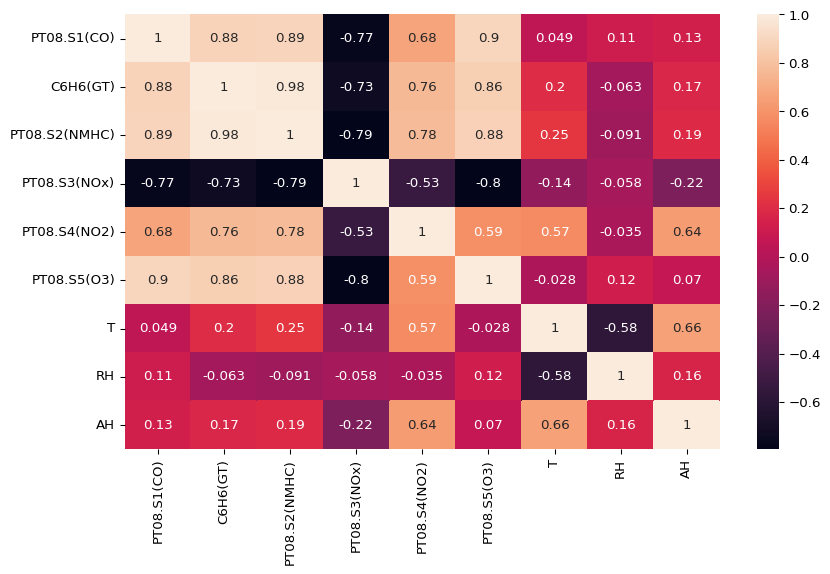

In [ ]:
# Heatmap to pinpoint the columns in the 'df' DataFrame exhibiting high correlation.
corr_df = df.iloc[:, 1:-4].corr()
plt.figure(figsize = (10, 6), dpi = 96)
sns.heatmap(data = corr_df, annot = True) # 'annot=True' fills the R values in the heatmap cells.
plt.show()

---

#### Train-Test Split

In [ ]:
# Splitting the DataFrame into the train and test sets.
from sklearn.model_selection import train_test_split

X = df['T'] # Pandas DataFrame containing only feature variables
y = df['RH'] # Pandas Series containing the target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42) # Test set will have 33% of the values.

# Create the 'errors_product()' and 'squared_errors()' function.
def errors_product():
  prod = (X_train - X_train.mean()) * (y_train - y_train.mean())
  return prod

def squared_errors():
  sq_errors = (X_train - X_train.mean()) ** 2
  return sq_errors

# Calculate the slope and intercept values for the best fit line.
slope = errors_product().sum()/ squared_errors().sum()
intercept = y_train.mean() - slope * X_train.mean()

print(f"Slope: {slope} \nIntercept: {intercept}")

Slope: -1.112053910794772 
Intercept: 69.69110324644876


Equation of the best fit line is
$$y = -1.1120x + 69.6911$$

or

$$\text{relative humidity} = -1.1120 \times \text{temperature} + 69.6911$$

which is also the regression line.

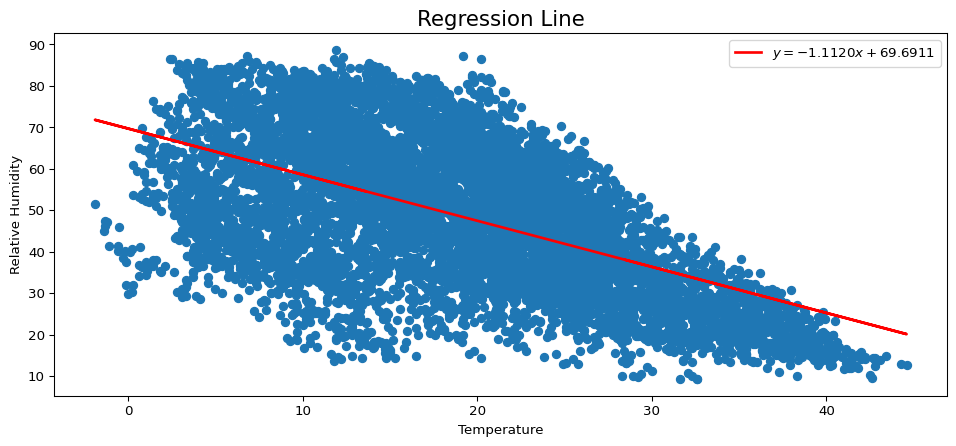

In [ ]:
# Plot the regression line in the scatter plot between relative humidity and temperature values.
plt.figure(figsize = (12, 5), dpi = 96)
plt.title("Regression Line", fontsize = 16)
plt.scatter(df['T'], df['RH'])
plt.plot(df['T'], slope * df['T'] + intercept, color = 'r', linewidth = 2, label = '$y = −1.1120x + 69.6911$')
plt.xlabel("Temperature")
plt.ylabel("Relative Humidity")
plt.legend()
plt.show()

---

#### Simple Linear Regression Using `sklearn` Module


In [ ]:
# Deploy linear regression model using the 'sklearn.linear_model' module.
from sklearn.linear_model import LinearRegression

X_train_reshaped = X_train.values.reshape(-1, 1)
y_train_reshaped = y_train.values.reshape(-1, 1)
X_test_reshaped = X_test.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)


lin_reg = LinearRegression()
lin_reg.fit(X_train_reshaped, y_train_reshaped)

print("Coefficient of $x$ (or slope) ==>", lin_reg.coef_)
print("Intercept ==>", lin_reg.intercept_)

Coefficient of $x$ (or slope) ==> [[-1.11205391]]
Intercept ==> [69.69110325]


In [ ]:
# Evaluate the linear regression model using the 'r2_score', 'mean_squared_error' & 'mean_absolute_error' functions of the 'sklearn' module.
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

y_train_pred = lin_reg.predict(X_train_reshaped)
y_test_pred = lin_reg.predict(X_test_reshaped)

print(f"Train Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_train_reshaped, y_train_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_train_reshaped, y_train_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_train_reshaped, y_train_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train_reshaped, y_train_pred):.3f}")

print(f"\n\nTest Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_test_reshaped, y_test_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_test_reshaped, y_test_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test_reshaped, y_test_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_reshaped, y_test_pred):.3f}")

Train Set
--------------------------------------------------
R-squared: 0.325
Mean Squared Error: 195.281
Root Mean Squared Error: 13.974
Mean Absolute Error: 11.289


Test Set
--------------------------------------------------
R-squared: 0.346
Mean Squared Error: 187.026
Root Mean Squared Error: 13.676
Mean Absolute Error: 11.150


For a highly accurate regression model:

- The $R^2$ squared value should be close to 1.

- The MSE, RMSE and MAE values should be close to zero. However, in the case of fractional values (or values between 0 and 1), MAE is a better metric to evaluate the accuracy of a regression-based prediction model.

---

#### Activity 1: Residual (Error) Analysis^^^

Before you can make a conclusion whether a prediction model is acceptable or not, you need to analyse residuals (or errors) to validate the assumptions of a linear regression model. Hence, the reliability of inference.

In the residual analysis, you need to check if the error terms are normally distributed (which is infact, one of the major assumptions of linear regression). Why? Because, formally, a simple linear regression model is given as

$$Y = \beta_0 + \beta_1 x + \epsilon$$

where

- $x$ is the independent variable

- $Y$ is the response to the independent variable (or predicted value or dependent variable)

- $\beta_0$ (intercept made by the best fit line with the $y$-axis) and $\beta_1$ (slope of the best fit line) are called regression coefficients

- **$\epsilon$** is the random error obtained along with the predicted value

**For a line to be the best fit line, the mean of random errors i.e. mean of $\epsilon$ should be 0.**

Let us plot the histogram of the error terms and see what it looks like.

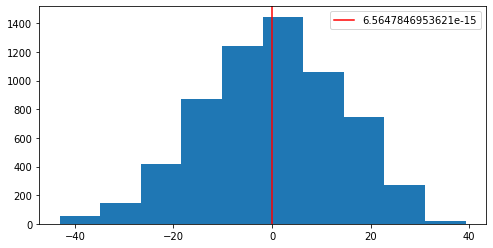

In [ ]:
# S1.1: Create a histogram for the errors obtained in the predicted values for the train set.
error_train = y_train_reshaped - y_train_pred
plt.figure(figsize = (8,4))
plt.hist(error_train)
plt.axvline(np.mean(error_train), color = 'red', label = error_train.mean())
plt.legend()
plt.show()

The residuals (or errors) somewhat follow a normal distribution with a mean equal to 0 which is what required. If the mean of errors between the actual and the predicted values is not equal to zero, then you need to rebuild the linear regression model probably with a different independent (or feature) variable.

Let's also create its normal distribution curve by applying the probability density function on the errors.

$$\rho(x) = \frac{1}{\sigma \sqrt{2 \pi}}e^{-\frac{1}{2\sigma^2}(x - \mu)^2}$$

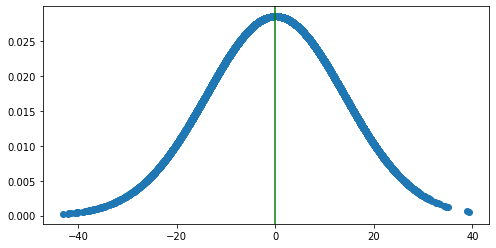

In [ ]:
# S1.2: Create a normal distribution curve for the errors obtained in the predicted values for the train set.
def prob_density_func(series):
  CONST = 1 / (series.std() * np.sqrt(2 * np.pi))
  power_of_e = - (series - series.mean()) ** 2 / (2 * series.var()) # 'pd.Series.var()' function returns the variance of the series.
  new_array = CONST * np.exp(power_of_e)
  return new_array

plt.figure(figsize = (8,4))
plt.scatter(error_train, prob_density_func(error_train))
plt.axvline(error_train.mean(), color = 'green', label = error_train.mean())
plt.show()

Clearly, the errors or residuals for the train set follow a normal distribution.

**The `norm.pdf()` Function**

You can also apply the probability density function using the `norm.pdf()` function of the `scipy.stats` module. To apply this function, you need to:

- Import the `norm` object from the `scipy.stats` module.

- Call the `pdf()` function on the `norm` object. It takes two inputs:

  1. The mean of the values

  2. The standard deviation of the values


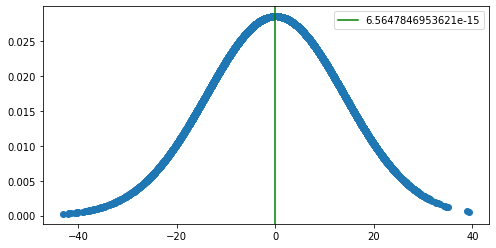

In [ ]:
# S1.3: Apply the 'norm.pdf()' function to get the probabilities and then create a normal distribution curve again for the train set errors.
from scipy.stats import norm
plt.figure(figsize = (8,4))
plt.scatter(error_train, norm.pdf(error_train, error_train.mean(), error_train.std()))
plt.axvline(error_train.mean(), color = 'green', label = error_train.mean())
plt.legend()
plt.show()

In [ ]:
norm.pdf(error_train, error_train.mean(), error_train.std())

array([[0.02492883],
       [0.02402283],
       [0.02036562],
       ...,
       [0.01380992],
       [0.018964  ],
       [0.02842518]])

In [ ]:
error_test = y_test_reshaped - y_test_pred

Let's repeat the above exercises for the test set as well.

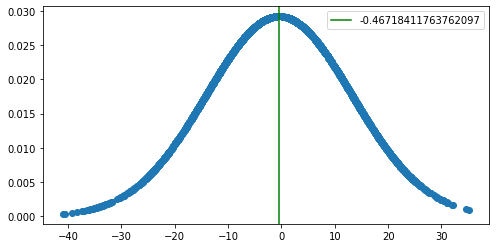

In [ ]:
# S1.4: Create a histogram for the errors obtained in the predicted values for the test set.
plt.figure(figsize = (8,4))
plt.scatter(error_test, norm.pdf(error_test, error_test.mean(), error_test.std()))
plt.axvline(error_test.mean(), color = 'green', label = error_test.mean())
plt.legend()
plt.show()

Here the mean of errors is NOT zero. Hence, it shows that our prediction model is not accurate and we will have to rebuild it.

---

#### Activity 2: Homoscedasticity & Heteroscedasticity^^

In addition to checking for the mean of errors, you also need to check for the trend in the scatter plot between the errors and the feature and target variables. There should not be a trend.

Let's create a scatter plot between the errors and the independent variable for the train set to see whether there is some kind of relationship between the two.

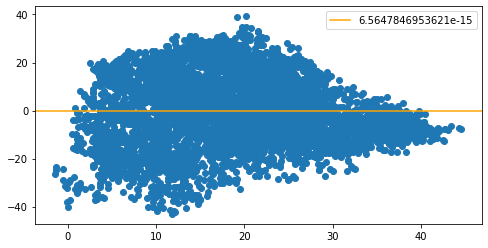

In [ ]:
# S2.1: Create a scatter plot between the errors and the independent variable for the train set
plt.figure(figsize = (8,4))
plt.scatter(X_train_reshaped, error_train)
plt.axhline(y = error_train.mean(), color = 'orange', label = error_train.mean())
plt.legend()
plt.show()

There is hardly any noticeable trend between the errors in the train set and the independent variable. This means the variance in the errors for the train set is approximately constant i.e. it is not changing much except for the rightmost points in the scatter plot. Hence, there is **homoscedasticity** between the errors w.r.t. the feature. In literal terms, **homo** means **same** and **scedasticity** means variance. So homoscedasticity means the same or constant variance. Homoscedasticity is good for us.

Now let's create a scatter plot between the errors and the target variable for the train set to see whether there is some kind of relationship between the two.

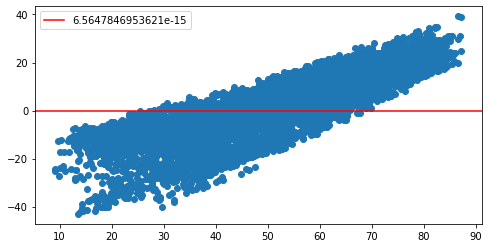

In [ ]:
# S2.2: Create a scatter plot between the errors and the dependent variable for the train set.
plt.figure(figsize = (8,4))
plt.scatter(y_train_reshaped, error_train)
plt.axhline(y = error_train.mean(), color = 'red', label = error_train.mean())
plt.legend()
plt.show()

There is some clear trend between errors and the target variable for the train set. This means the variance in the error terms is varying from left-to-right. Hence, there is **heteroscedasticity** (not same variance) between in the errors w.r.t. the predicted values. This is not a good thing for us.

So after going through all the necessary evaluation steps, we can say that our linear regression model i.e.

$$\text{relative humidity} = -1.1214 \times \text{temperature} + 69.6313$$

is poor because of the following reasons:

- $R^2$ value is low
- MSE, RMSE, MAE values are high
- The mean of errors for the test set is non-zero
- Presence of heteroscedasticity between the errors in the train set and the predicted values

Hence, we can need to rebuild the linear regression model with more feature (or independent) variables. This is where we have to implement multiple linear regression to build a more accurate prediction model.

---

#### Activity 3: Multiple Linear Regression^

In multiple linear regression, you have more than one feature to predict the target.

$$Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \dots + \beta_n x_n + \epsilon$$

where

- $x_1, x_2, x_3, \dots , x_n$ are independent variables or features

- $Y$ is the response to the independent variable (or predicted value or dependent variable)

- $\beta_0, \beta_1, \beta_2, \dots, \beta_n$ are the corresponding regression coefficients of the independent variables

- **$\epsilon$** is the random error obtained along with the predicted value

In this case, to predict relative humidity (the target to be predicted), we will consider all the features except for `'DateTime'` because it is not a numeric value. So the above regression equation becomes

$$\text{RH} = \beta_0 + \beta_1 \space{} \text{CO} + \beta_2 \space{} \text{C}_6 \text{H}_6 + \beta_3 \space{} \text{NMHC} + \beta_4 \space{} \text{NO}_x + \beta_5 \space{} \text{NO}_2 + \beta_6 \space{} \text{O}_3 + \beta_7 \space{} \text{T} + \beta_8 \space{} \text{AH} + \beta_9 \space{} \text{year} + \beta_{10} \space{} \text{month} + \beta_{11} \space{} \text{day} + \epsilon$$

For illustration, consider only three features that are $\text{CO}, \text{T}$ and $\text{AH}$ and coefficients 14, 2, -3 and 5. So the above equation becomes
$$y = 14 + 2 x_1 -3 x_2 + 5 x_3$$

or
$$\text{RH} = 14 + 2\text{CO} -3 \text{T} + 5 \text{AH}$$

So when

- all three parameters are $0$, then the absolute humidity will always be $14$

- all three parameters are $1$, then the absolute humidity is $14 + 2 - 3 + 5 = 18$

Similarly, you can simulate all the possible cases for the above three parameters in the illustration.

Now, you may not require all the 11 features to predict relative humidity values. You may have to eliminate a few of the above features. Soon you will get to know why.

So our next task is to estimate the values of the coefficients that we will do in the next class.

---